In [1]:
from keras.models import load_model
from model import get_personlab
from resnet101 import get_resnet101_base
from scipy.ndimage.filters import gaussian_filter
import cv2
import numpy as np
from time import time
from config import config

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


Load model with Train=False.
This model was trained with intermediate supervision from the layer specified,
so we'll load the whole thing including those extra prediction layers.

In [2]:
tic = time()
model = get_personlab(train=False, with_preprocess_lambda=True,
                      intermediate_supervision=True,
                      intermediate_layer='res4b12_relu',
                      build_base_func=get_resnet101_base,
                      output_stride=16)
print 'Loading time: {}'.format(time()-tic)

Loading time: 35.1143918037


In [3]:
model.load_weights('models/personlab_res101_400_r32_0510.h5')

In [4]:
# Pad image appropriately (to match raltionship to output_stride as in training)
def pad_img(img, mult=16):
    h, w, _ = img.shape
    
    h_pad = 0
    w_pad = 0
    if (h-1)%mult > 0:
        h_pad = mult-((h-1)%mult)
    if (w-1)%mult > 0:
        w_pad = mult-((w-1)%mult)
    return np.pad(img, ((0,h_pad), (0,w_pad), (0,0)), 'constant')

img = cv2.imread('/home/jacob/Datasets/coco_val/val2017/000000013291.jpg')
img = cv2.resize(img, (0,0), fx=.9, fy=.9)
img = pad_img(img)
print 'Image shape: {}'.format(img.shape)

Image shape: (305, 465, 3)


In [5]:
outputs = model.predict(img[np.newaxis,...])
# Remove batch axes and remove intermediate predictions
outputs = [o[0] for o in outputs][5:]

<IPython.core.display.Javascript object>


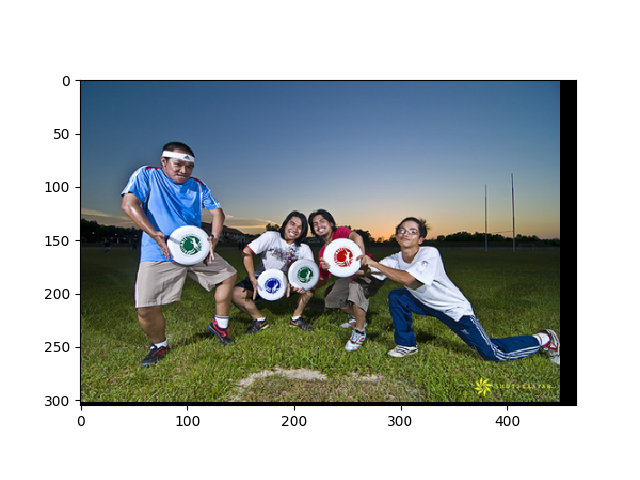

In [6]:
plt.figure()
img = img[:,:,[2,1,0]]
plt.imshow(img)

Let's take a look at the outputs...

**Keep in mind that this model checkpoint was saved after only 35 epochs (less than one third the amount trained in the paper), so the results are expected to be sub-optimal**.

In [7]:
from plot import *

def overlay(img, over, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    out *= 1-alpha
    if len(over.shape)==2:
        out += alpha*over[:,:,np.newaxis]
    else:
        out += alpha*over    
    return out


<IPython.core.display.Javascript object>


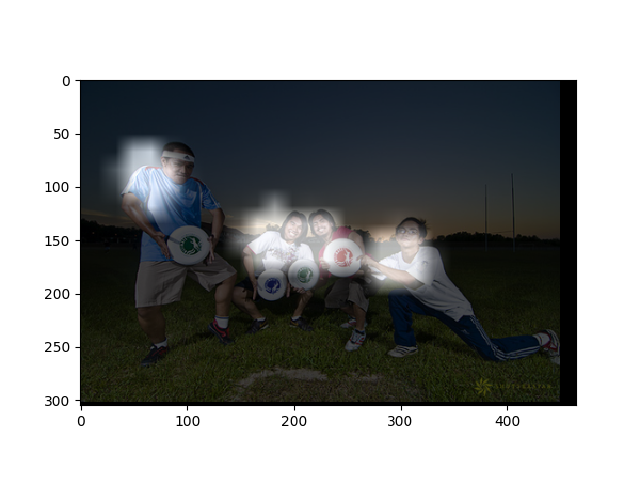

In [8]:
# Here is the output map for right shoulder
Rshoulder_map = outputs[0][:,:,config.KEYPOINTS.index('Rshoulder')]
plt.figure()
plt.imshow(overlay(img, Rshoulder_map, alpha=0.7))

<IPython.core.display.Javascript object>


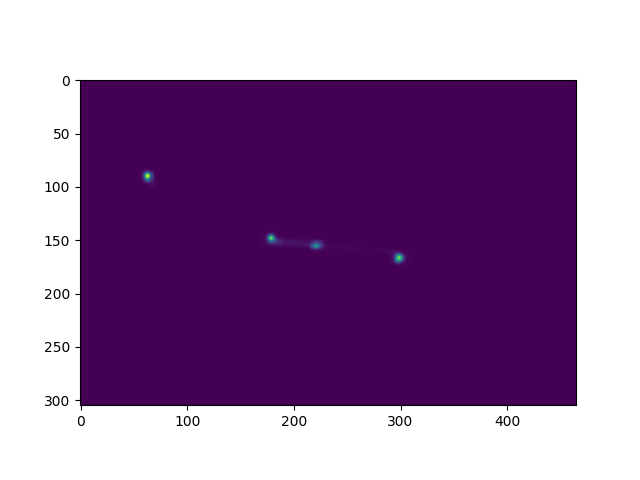

In [9]:
from post_proc import *

H = compute_heatmaps(kp_maps=outputs[0], short_offsets=outputs[1])
# Gaussian filtering helps when there are multiple local maxima for the same keypoint.
for i in range(17):
    H[:,:,i] = gaussian_filter(H[:,:,i], sigma=2)
    
plt.figure()
plt.imshow(H[:,:,config.KEYPOINTS.index('Rshoulder')])

<IPython.core.display.Javascript object>


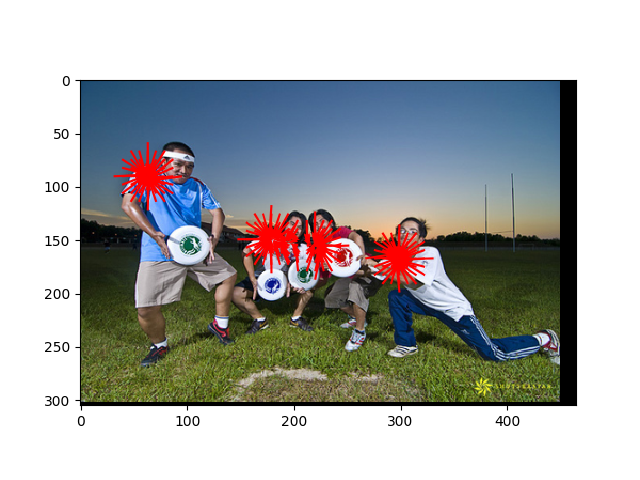

In [10]:
# The heatmaps are computed using the short offsets predicted by the network
# Here are the right shoulder offsets
visualize_short_offsets(offsets=outputs[1], heatmaps=H, keypoint_id='Rshoulder', img=img, every=8)

<IPython.core.display.Javascript object>


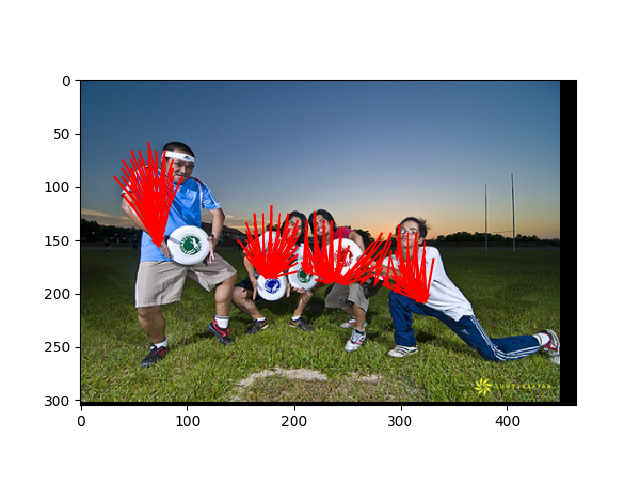

In [11]:
# The connections between keypoints are computed via the mid-range offsets.
# We can visuzalize them as well; for example right shoulder -> right hip
visualize_mid_offsets(offsets= outputs[2], heatmaps=H, from_kp='Rshoulder', to_kp='Rhip', img=img, every=8)

<IPython.core.display.Javascript object>


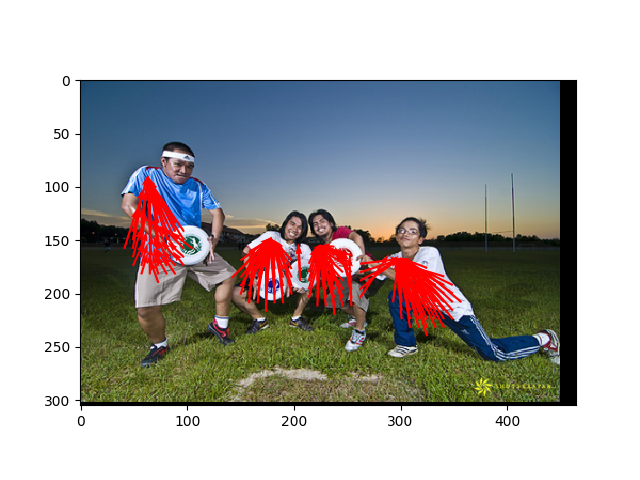

In [12]:
# And we can see the reverse connection (Rhip -> Rshjoulder) as well
visualize_mid_offsets(offsets= outputs[2], heatmaps=H, to_kp='Rshoulder', from_kp='Rhip', img=img, every=8)

Number of detected skeletons: 5


<IPython.core.display.Javascript object>


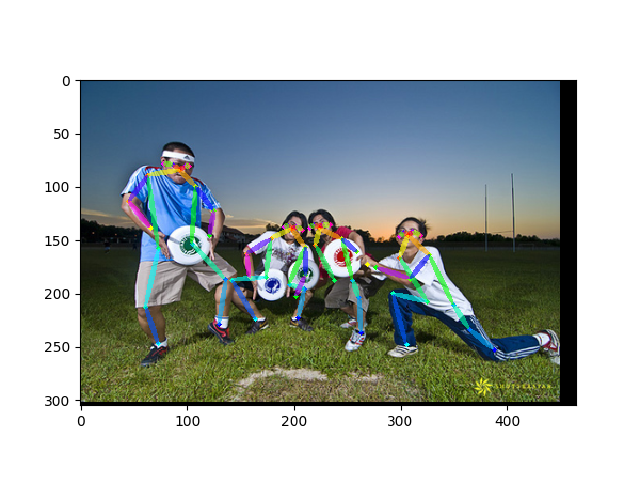

In [13]:
# We can use the heatmaps to compute the skeletons
pred_kp = get_keypoints(H)
pred_skels = group_skeletons(keypoints=pred_kp, mid_offsets=outputs[2])
print 'Number of detected skeletons: {}'.format(len(pred_skels))

plot_poses(img, pred_skels)

Even though there are four people in the image, we detected five skeletons. The reason for that is that the right wrist of the person on the far right of the image has been detected, but not connected to the rest of his skeleton, so it counts as it's own skeleton with one joint. We can therefore remove any skeletons without a certain threshold number of joints (say, 4).

In [14]:
pred_skels = [skel for skel in pred_skels if (skel[:,2]>0).sum() > 4]

Finally, we can use the predicted skeletons along with the long-range offsets and binary segmentation mask to compute the instance masks. First, let's look at the binary mask predicted by the net.

<IPython.core.display.Javascript object>


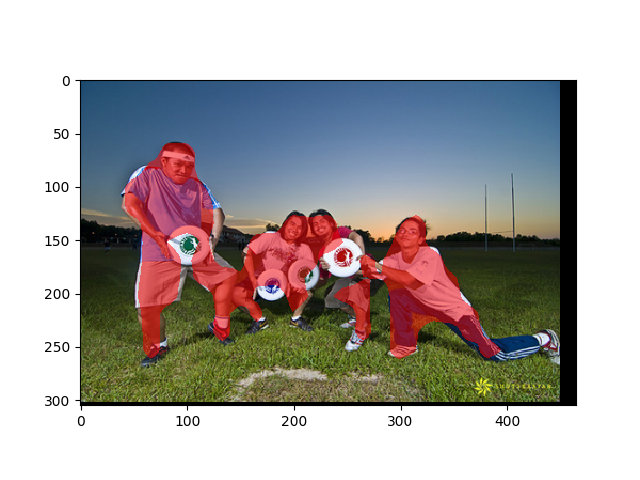

In [15]:
plt.figure()
plt.imshow(apply_mask(img, outputs[4][:,:,0]>0.5, color=[1,0,0]))

<IPython.core.display.Javascript object>


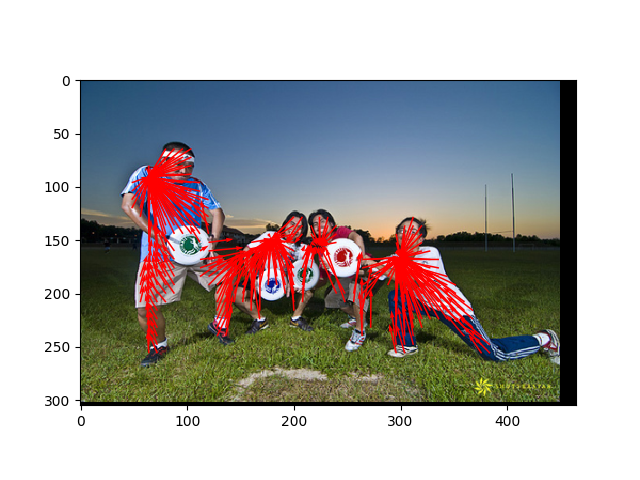

In [16]:
visualize_long_offsets(offsets=outputs[3], keypoint_id='Rshoulder', seg_mask=outputs[4], img=img, every=8)

<IPython.core.display.Javascript object>


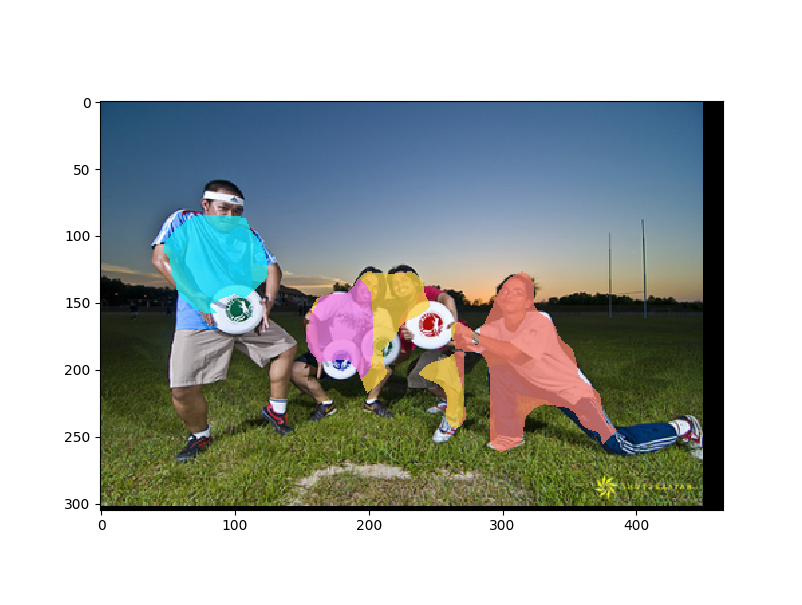

In [24]:
instance_masks = get_instance_masks(pred_skels, outputs[-1][:,:,0], outputs[-2])
plot_instance_masks(instance_masks, img)